In [48]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
        path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [49]:
import time
from datetime import timedelta
from pprint import pprint
import corner
import numpy as np
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS

from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
import lenstronomy.Util.util as util
from utils import psf_utils
from lenstronomy.Util import kernel_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel

from utils import csv_utils

Import data: grade A, IR, source and deflector spectroscopic redshifts

In [50]:
csv_filepath = os.path.join(repo_path, 'data', 'SLACS', 'SLACS.csv')
dataset_dict_list = csv_utils.csv_to_dict_list(csv_filepath)

In [51]:
data_set_name = 'J9EM25AFQ'

# TODO run J9OP02010 again now that I've fixed the PSF which seems to do a better job for the centers

# J9OP02010 - fine
# J9EM25AFQ - fine
# J9OP04010 - weirdness around arcs but eh

dataset = [d for d in dataset_dict_list if d.get('data_set_name') == data_set_name][0]

pprint(dataset)

ra, dec = float(dataset.get('ra')), float(dataset.get('dec'))

{'AI': '0.02',
 'Fiber': '7',
 'Imag': '15.52',
 'L(V555)': '51.4',
 'Le2/LdV': '0.324',
 'Lens': 'A',
 'MJD': '52652',
 'Mph': 'E',
 'Mul': 'S',
 'Name': 'J1106+5228',
 'PA': '57.3',
 'Plate': '1011',
 'Re': '1.68',
 'SDSS': '110646.15+522837.8',
 '_DE': '52.47717',
 '_RA': '166.69229',
 'actual_duration': '420.0',
 'aper': 'WFC1',
 'b/a': '0.63',
 'central_wavelength': '8047.8062',
 'cutout': '',
 'cutout_filepath': '/data/bwedig/roman-pandeia/data/cutouts/SLACS/cutout_WFC1_CLEAR1L;F814W_J9EM25AFQ.fits',
 'data_set_name': 'J9EM25AFQ',
 'data_uri': 'mast:HST/product/j9em25afq_drz.fits',
 'dec': '52.47713888889',
 'e_sigma': '13',
 'filename': 'j9em25afq_drz.fits',
 'fits_filepath': '/data/bwedig/roman-pandeia/data/mastDownload/SLACS/j9em25afq_drz.fits',
 'instrument': 'ACS   ',
 'n_Imag': 's',
 'n_Lens': ' ',
 'peak_value': '',
 'preview_name': 'J9EM25AFQ',
 'ra': '166.6923333333',
 'recno': '51',
 'release_date': '2006-10-16T12:17:03.490000',
 'sigma': '262',
 'spec': 'CLEAR1L;F814W'

Open `.fits` file

In [52]:
with fits.open(dataset.get('cutout_filepath')) as hdu_list:
    hdu_list.verify()
    hdu_list.info()
    data = hdu_list['PRIMARY'].data
    header = hdu_list['PRIMARY'].header

wcs = WCS(header=hdu_list['PRIMARY'].header)

Filename: /data/bwedig/roman-pandeia/data/cutouts/SLACS/cutout_WFC1_CLEAR1L;F814W_J9EM25AFQ.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      92   (300, 300)   float32   


Take a quick look at the image

/tmp/ipykernel_38728/1022304046.py:4: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(data), origin='lower')


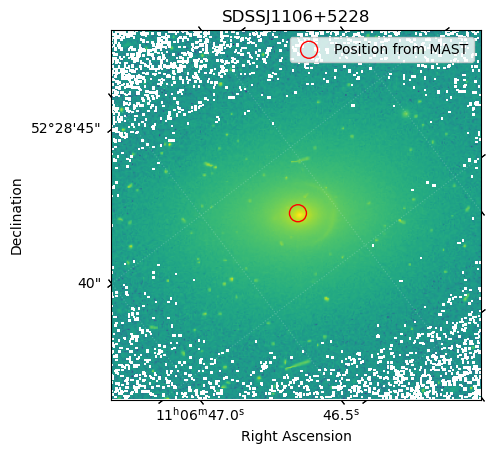

In [53]:
center_pixel_y, center_pixel_x = wcs.all_world2pix(ra, dec, 1, adaptive=False, ra_dec_order=True)

ax = plt.subplot(projection=wcs)
ax.imshow(np.log10(data), origin='lower')
plt.grid(color='white', ls=':', alpha=0.2)
plt.scatter(center_pixel_x, center_pixel_y, edgecolor='red', facecolor='none', s=150, label='Position from MAST')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title(dataset.get('target_name'))
plt.legend()
plt.show()

Crop down to 5x5 arcseconds

In [54]:
# num_pix = 175

sky_coords = SkyCoord(ra, dec, unit='deg', frame='icrs')
# size = u.Quantity((num_pix, num_pix), u.pixel)
size = u.Quantity((5, 5), u.arcsec)
cutout_obj = Cutout2D(data, sky_coords, size, wcs=wcs)

# overwrite data and wcs
data = cutout_obj.data
wcs = cutout_obj.wcs

print(cutout_obj.shape)

(100, 100)


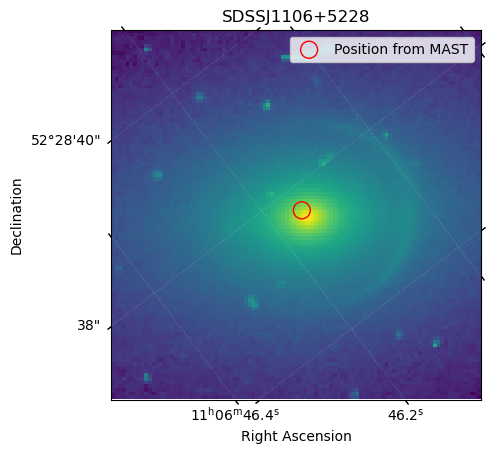

In [55]:
center_pixel_y, center_pixel_x = wcs.all_world2pix(ra, dec, 1, adaptive=False, ra_dec_order=True)

ax = plt.subplot(projection=wcs)
ax.imshow(np.log10(data), origin='lower')
plt.grid(color='white', ls=':', alpha=0.2)
plt.scatter(center_pixel_x, center_pixel_y, edgecolor='red', facecolor='none', s=150, label='Position from MAST')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title(dataset.get('target_name'))
plt.legend()
plt.show()

Calculate the background RMS

Background RMS: 0.13944598633891006


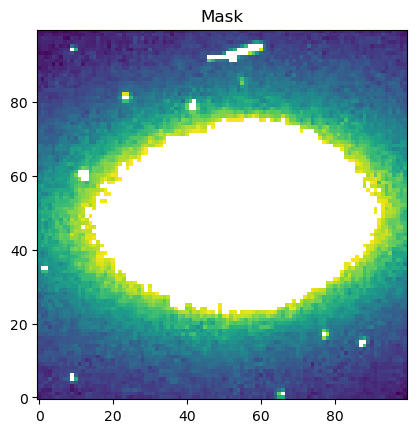

In [56]:
from astropy import stats

cut_mask = stats.sigma_clip(data, sigma=2, maxiters=5)
rms = np.std(cut_mask)

print('Background RMS: ' + str(rms))

plt.imshow(cut_mask, origin='lower')
plt.title('Mask')
plt.show()

Pull data from header and calculate transformations

In [57]:
from datetime import datetime

# data specifics
start_time = datetime.fromisoformat(dataset.get('start_time'))
stop_time = datetime.fromisoformat(dataset.get('stop_time'))
background_rms = rms  # background noise per pixel
exp_time = (stop_time - start_time).seconds  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
pixel_scale = float(header.get('D001SCAL'))  # pixel size in arcsec (area per pixel = pixel_scale**2)

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header.get('CD1_1') * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header.get('CD1_2') * 3600
CD2_1 = header.get('CD2_1') * 3600
CD2_2 = header.get('CD2_2') * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# read out pixel size of image
# nx, ny = header.get('NAXIS1'), header.get('NAXIS2')
# but these values are for the original fits file, so use updated values
nx, ny = data.shape
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))

# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

Import PSF `.fits` file

???????????????????????????????????????????????????????????????????????????????? [astropy.io.fits.card]
/tmp/ipykernel_38728/3783038541.py:10: RuntimeWarning: divide by zero encountered in log10
  ax1.matshow(np.log10(psf_data), origin='lower')
/tmp/ipykernel_38728/3783038541.py:10: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(psf_data), origin='lower')


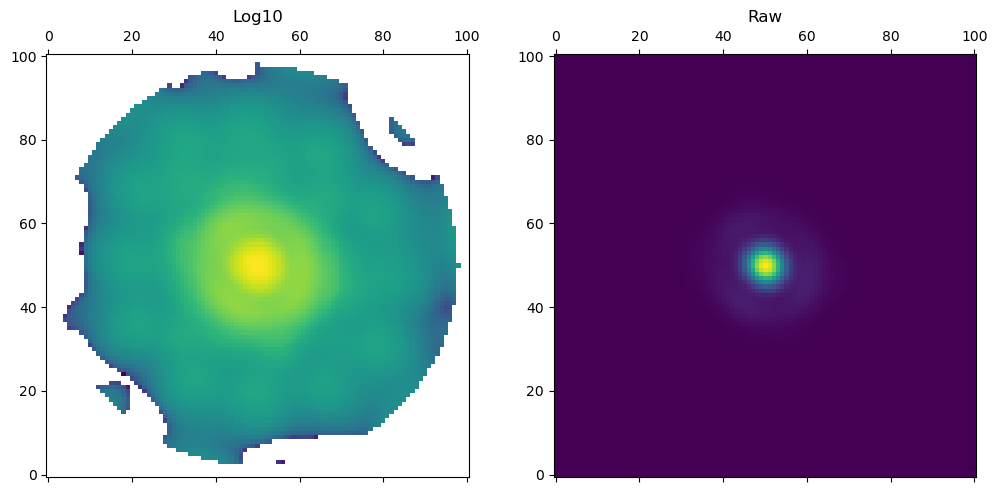

101 (101, 101)


In [58]:
psf_filepath = os.path.join(repo_path, 'psfs', 'PSFSTD_WFC3UV_F814W.fits')

with fits.open(psf_filepath, ignore_missing_end=True) as hdu_list:
    # hdu_list.verify()
    psf_data = hdu_list['PRIMARY'].data[17]  # middle of first chip
    psf_header = hdu_list['PRIMARY'].header

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.matshow(np.log10(psf_data), origin='lower')
ax2.matshow(psf_data, origin='lower')

title1 = 'Log10'
ax1.set_title(title1)
title2 = 'Raw'
ax2.set_title(title2)

plt.show()

# if kernel needs to be cut down, lenstronomy has a method for that
kernel_size = psf_header.get('NAXIS1')  # PSF kernel size (odd number required).
print(kernel_size, psf_data.shape)
kernel_cut = kernel_util.cut_psf(psf_data, kernel_size)
psf_pix_map = kernel_util.degrade_kernel(psf_data - np.min(psf_data), 2)


Pull PSF in to `lenstronomy`

Getting `fwhm` number from [here](https://hst-docs.stsci.edu/wfc3ihb/chapter-6-uvis-imaging-with-wfc3/6-6-uvis-optical-performance)

In [59]:
# kwargs_psf = psf_utils.get_none_kwargs_psf()
# kwargs_psf = psf_utils.get_gaussian_kwargs_psf(fwhm=0.074, pixel_size=pixel_scale, truncation=3)
kwargs_psf = {
    'psf_type':'PIXEL',
    'kernel_point_source': psf_pix_map,
    'point_source_supersampling_factor': 2
}
psf_class = psf_utils.get_psf_class(kwargs_psf)

## Get macrolens model

Prepare `ImageData` class

In [60]:
from lenstronomy.Data.imaging_data import ImageData

kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': pix2coord_transform_undistorted,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix), units of arcseconds
               'image_data': data
              }

data_class = ImageData(**kwargs_data)
data_class.update_data(data)

Define guesses (spread and bounds for all parameters). Then, run particle swarm optimization (PSO) to minimize $\chi^2$

In [61]:
# lens params
lens_model_list = ['SIE', 'SHEAR']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})  # fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append({'theta_E': 1., 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': 0.5, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10., 'center_y': -10.})
kwargs_upper_lens.append({'theta_E': 3., 'e1': 0.5, 'e2': 0.5, 'center_x': 10., 'center_y': 10.})

# fixed_lens.append({})
fixed_lens.append({'ra_0': 0., 'dec_0': 0.})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# source params
source_model_list = ['SERSIC_ELLIPSE']

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0, 'amp': 5.})
kwargs_source_sigma.append({'R_sersic': 0.1, 'n_sersic': 0.5, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2, 'amp': 1.})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10, 'amp': 5.})
kwargs_upper_source.append({'R_sersic': 10., 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10, 'amp': 10.})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# lens light params
lens_light_model_list = ['SERSIC_ELLIPSE']

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_lens_light_sigma.append({'R_sersic': 0.3, 'n_sersic': 1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1, 'amp': 10})
kwargs_lower_lens_light.append({'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'R_sersic': 10., 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10, 'amp': 100})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}  # NB add special params here if using them

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

In [62]:
kwargs_likelihood = {'source_marg': False}
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
# if you have multiple bands to be modeled simultaneously, you can append them to the multi_band_list

kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'single-band'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }
kwargs_constraints = {'linear_solver': True}  # optional, if 'linear_solver': False, lenstronomy does not apply a linear inversion of the 'amp' parameters during fitting but instead samples them.

Take a look at the initial parameters next to image we're fitting

In [63]:
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': pix2coord_transform_undistorted}
pixel_grid = PixelGrid(**kwargs_pixel)

lens_model_class = LensModel(lens_model_list=lens_model_list)
source_model_class = LightModel(light_model_list=source_model_list)
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens=kwargs_lens_init, kwargs_source=kwargs_source_init,
                             kwargs_lens_light=kwargs_lens_light_init)

# f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex='none', sharey='none')
# ax = axes
# axes.matshow(image_sim, origin='lower')
# axes.get_xaxis().set_visible(False)
# axes.get_yaxis().set_visible(False)
# axes.autoscale(False)
# plt.title('Initial Parameters')
# plt.show()

/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/Data/psf.py:126: Warning: Super-sampled point source kernel over-written due to different subsampling size requested.
  warnings.warn("Super-sampled point source kernel over-written due to different subsampling"


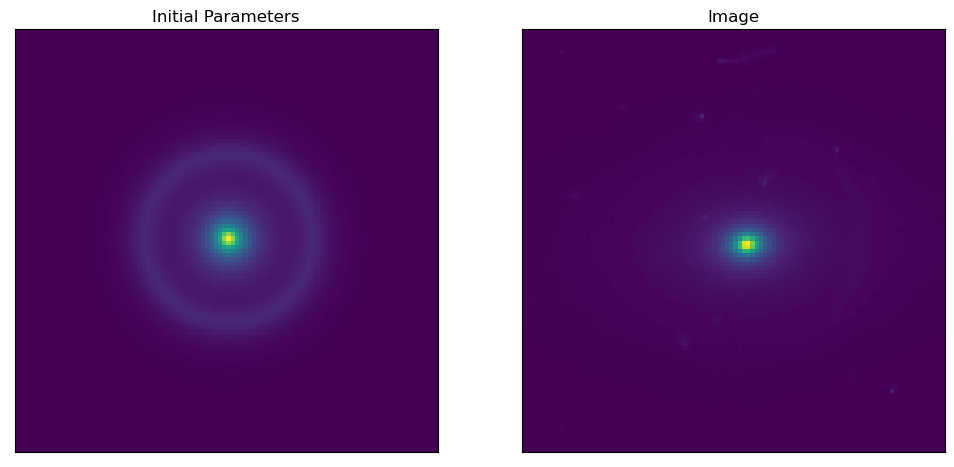

In [64]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.matshow(image_sim, origin='lower')
ax2.imshow(data, origin='lower')

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

title1 = 'Initial Parameters'
ax1.set_title(title1)
title2 = 'Image'
ax2.set_title(title2)

plt.show()

Perform fitting

In [65]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

# pso = ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}]
pso = ['PSO', {'sigma_scale': 1., 'n_particles': 400, 'n_iterations': 400}]
# mcmc = ['MCMC', {'n_burn': 20, 'n_run': 20, 'walkerRatio': 4, 'sigma_scale': .1, 'threads': thread_count}]
# mcmc = ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}]
mcmc = ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers': 200, 'sigma_scale': .1}]
fitting_kwargs_list = [pso, mcmc]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
execution_time = round(end_time - start_time)
print(timedelta(seconds=execution_time), 'total time needed for computation')

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
Max iteration reached! Stopping.
-0.7982087224266934 reduced X^2 of best position
-3982.6624205479866 log likelihood
9979 effective number of data points
[{'theta_E': 1.1951513720352138, 'e1': 0.28568207049753624, 'e2': 0.39913196178110305, 'center_x': 0.2579965585259687, 'center_y': 0.08507093263336346}, {'gamma1': 0.1586679108775867, 'gamma2': 0.19975947799908908, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 9.999041331388872, 'n_sersic': 2.783014505715996, 'e1': -0.10557584356866365, 'e2': -0.04605779226066545, 'center_x': -0.13305455229374788, 'center_y': -0.22440424804689027}] source result
[{'amp': 1, 'R_sersic': 1.012234726366965, 'n_sersic': 4.999913251608183, 'e1': 0.09098828097738508, 'e2': 0.1931570115893118, 'center_x': -0.06537885701462934, 'center_y': -0.13472272847250552}] lens ligh

100%|██████████| 800/800 [18:21<00:00,  1.38s/it]

Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  200
Sampling iterations (in current run): 800
1103.2386922836304 time taken for MCMC sampling
0:34:33 total time needed for computation


Plot results of MCMC chain

-0.7942445633021643 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7942445633021641


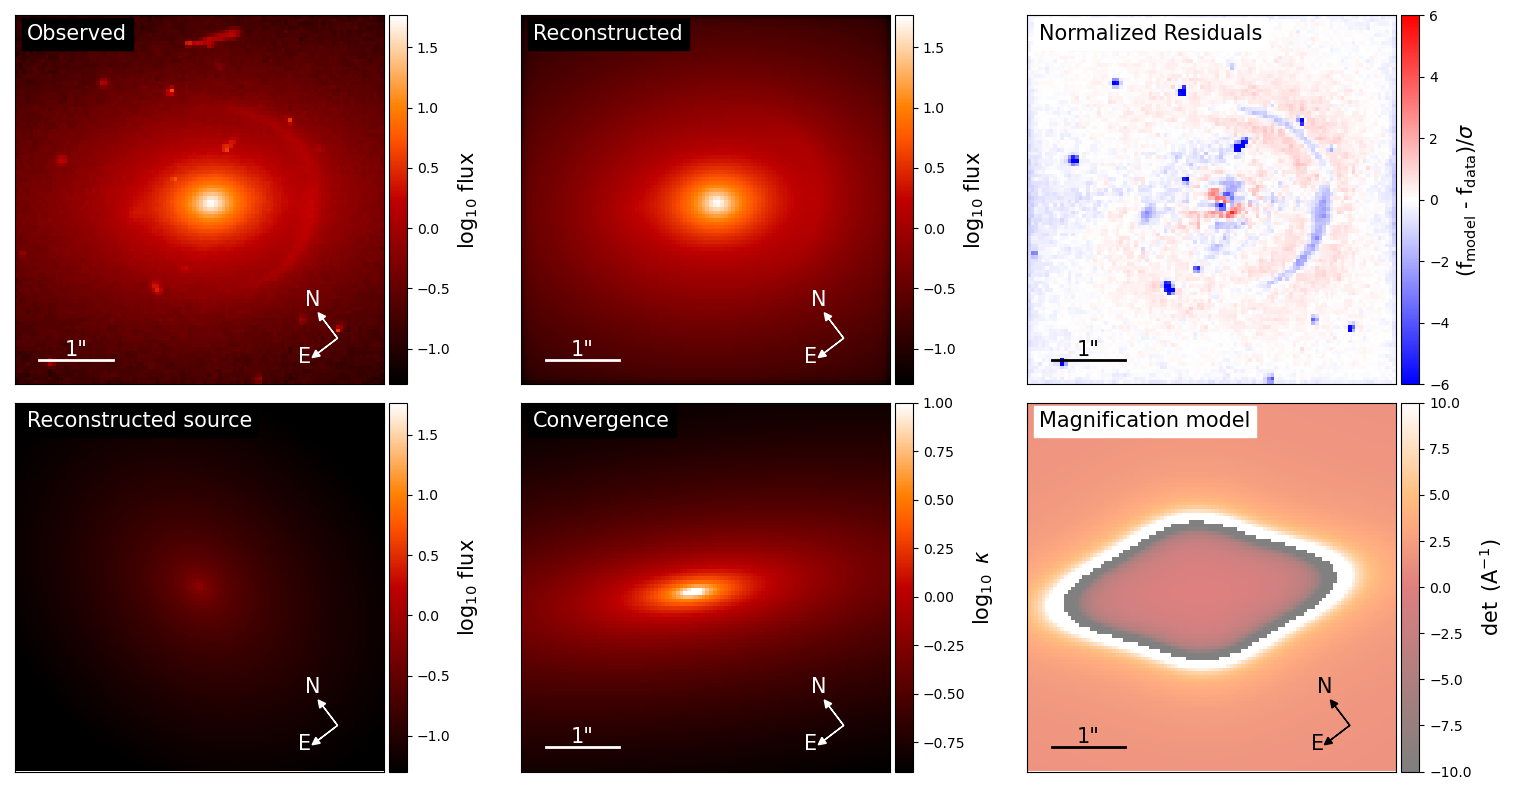

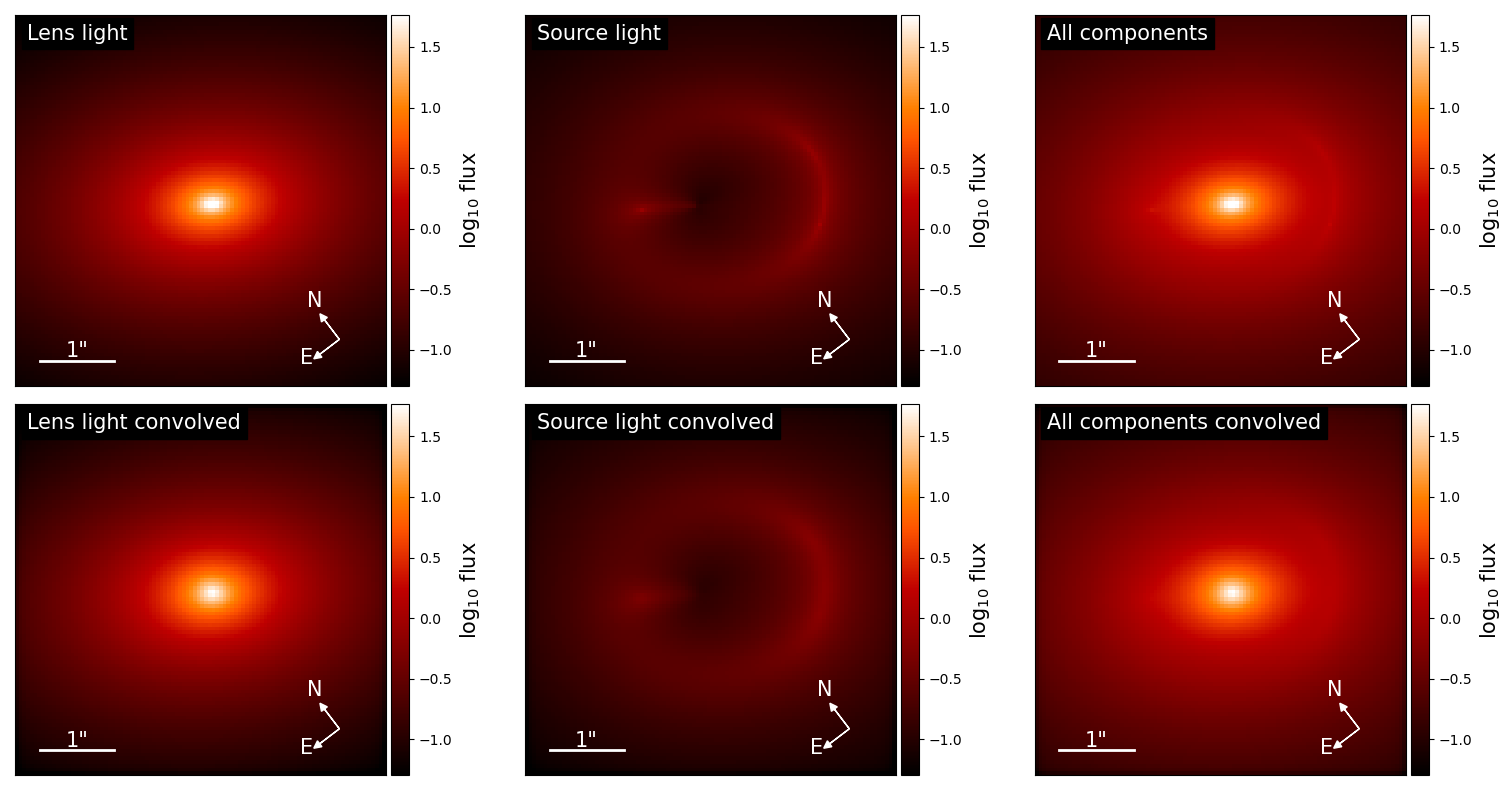

In [66]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat", linear_solver=kwargs_constraints.get('linear_solver', True))
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex='none', sharey='none')

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=pixel_scale, numPix=nx)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
f.show()
f.savefig(os.path.join(repo_path, 'figures', 'lenstronomy_modeling', data_set_name + '_p1.png'))

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex='none', sharey='none')

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
f.show()
f.savefig(os.path.join(repo_path, 'figures', 'lenstronomy_modeling', data_set_name + '_p2.png'))

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  120000
120000


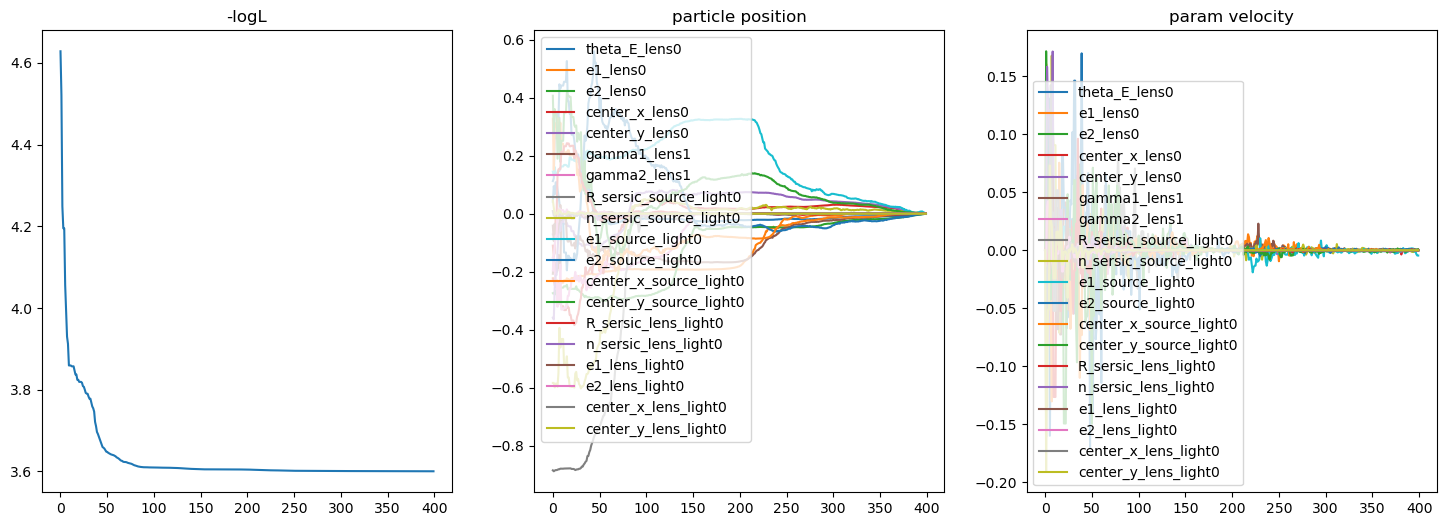

<Figure size 640x480 with 0 Axes>

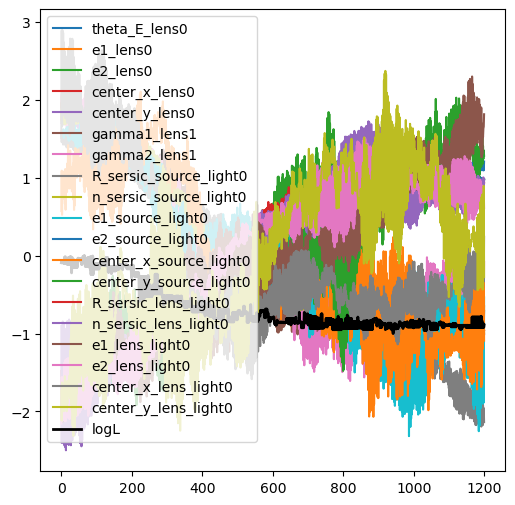

In [67]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
param_class = fitting_seq.param_class

for i in range(len(chain_list)):
    f, axes = chain_plot.plot_chain_list(chain_list, i)
    f.savefig(os.path.join(repo_path, 'figures', 'lenstronomy_modeling', data_set_name + '_p' + str(i + 3) + '.png'))


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
n_sample = len(samples_mcmc)
print(n_sample)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]

Retrieve macrolens parameters from fitting

In [68]:
pprint(kwargs_result)

kwargs_macromodel_lens = kwargs_result.get('kwargs_lens')
kwargs_macromodel_lens_light = kwargs_result.get('kwargs_lens_light')
kwargs_macromodel_ps = kwargs_result.get('kwargs_ps')
kwargs_macromodel_source = kwargs_result.get('kwargs_source')
kwargs_macromodel_special = kwargs_result.get('kwargs_special')

cache_path = os.path.join(repo_path, 'data', 'cache')

{'kwargs_extinction': [],
 'kwargs_lens': [{'center_x': 0.1980218870006634,
                  'center_y': 0.0454810534979207,
                  'e1': 0.25542805482374475,
                  'e2': 0.45315476056231646,
                  'theta_E': 1.2851708934709123},
                 {'dec_0': 0.0,
                  'gamma1': 0.13872874511508784,
                  'gamma2': 0.18928734167710698,
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'R_sersic': 1.0234517779412242,
                        'amp': 389.7466057652519,
                        'center_x': -0.06551512236331729,
                        'center_y': -0.13454269904605035,
                        'e1': 0.09145210523745106,
                        'e2': 0.19678589434608915,
                        'n_sersic': 4.992332513233228}],
 'kwargs_ps': [],
 'kwargs_source': [{'R_sersic': 9.971153219749985,
                    'amp': 3.1555713482940617,
                    'center_x': -0.13156257737671495,
                    

Take a look at the fitted macrolens model

In [69]:
modeled_lenses_dir = os.path.join(repo_path, 'data', 'modeled_lenses')

lens_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_lens'), 'ab')
pickle.dump(kwargs_macromodel_lens, lens_file)
lens_file.close()

lens_light_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_lens_light'), 'ab')
pickle.dump(kwargs_macromodel_lens_light, lens_light_file)
lens_light_file.close()

source_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_source'), 'ab')
pickle.dump(kwargs_macromodel_source, source_file)
source_file.close()

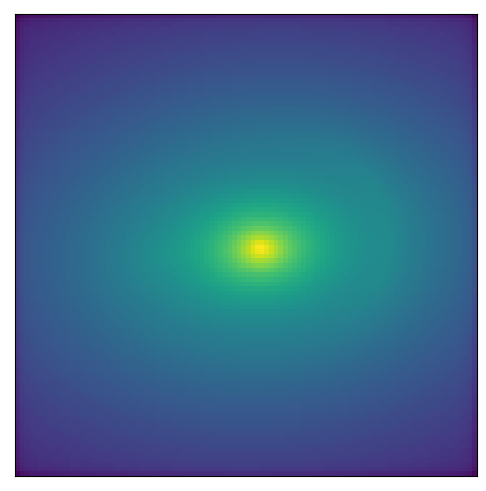

In [70]:
lens_model_class = LensModel(lens_model_list=lens_model_list)
source_model_class = LightModel(light_model_list=source_model_list)
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, lens_light_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_macromodel_lens, kwargs_macromodel_source, kwargs_macromodel_lens_light)

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex='none', sharey='none')
ax = axes
axes.matshow(np.log10(image_sim), origin='lower')
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)
axes.autoscale(False)
plt.show()